In [1]:
import sp_peaks
from sp_peaks import slics
import numpy as np

In [2]:
import os

# Define root directory where the simulation files are located
root_directory = "/n17data/tersenov/SLICS/Cosmo_DES"

# Directories to exclude
exclude_dirs = ["SLICS_HR", "fid_a", "fid_f"]

# Open the master text file in write mode
master_file_path = "master_file.txt"
with open(master_file_path, "w") as master_file:
    # Iterate over the files and subdirectories in the root directory
    for root, dirs, files in os.walk(root_directory):
        # Exclude the specified directories
        dirs[:] = [d for d in dirs if d not in exclude_dirs]
        
        for file_name in files:
            # Write the file path to the master file
            file_path = os.path.join(root, file_name)
            master_file.write(file_path + "\n")

In [2]:
import sp_peaks
from sp_peaks import slics

# Read the file paths from master_file.txt
filename = "master_file.txt"
with open(filename, 'r') as file:
    file_paths = file.readlines()
    file_paths = [path.strip() for path in file_paths]

filename_data = slics.read_SLICS_cats(file_paths)

In [3]:
# Path to the .dat file
dat_file_path = "/home/tersenov/shear-pipe-peaks/example/CosmoTable.dat"

# Read the cosmological parameters from the .dat file
cosmo_params = slics.read_SLICS_cosmo_params(dat_file_path)

In [4]:
dat_file_path = "/home/tersenov/shear-pipe-peaks/example/CosmoTable.dat"
mapped_params = slics.map_cosmo_params_to_data(filename_data, dat_file_path)

# Generate the mass map from the catalog, make the S/N maps and count the peaks

Catalog columns:

0. RA
1. DEC
2. e1_data
3. e2_data
4. w 
5. redshift_true_sim
6. gamma1_sim
7. gamma2_sim
8. kappa_sim
9. s_metacal_data

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from lenspack.geometry.projections.gnom import radec2xy
from lenspack.utils import bin2d
from lenspack.image.inversion import ks93
import lenspack.peaks as peaks
from lenspack.starlet_l1norm import noise_coeff, get_l1norm_noisy
from lenspack.image.transforms import starlet2d
from astropy.stats import mad_std

In [6]:
# Constants and Parameters
CATALOG_FILE = "/n17data/tersenov/SLICS/Cosmo_DES/16_a/LOS4/DES_MocksCat_16_a_4_Bin3_LOS4_R4.dat"
N_GAL = 7
PIX_ARCMIN = 0.4
SHAPE_NOISE = 0.44
NSCALES = 5
NBINS = 40 
KAPPA_SNR = np.linspace(-2, 6, 31)

In [17]:
# we should discuss this- the following functions will go into a mass-map module that will 
# contain the different methods.  do they all require binned data?, 
# at any rate, we should have a separate binning function

def plot_map(map_data, title='', cmap='inferno', vmin=None, vmax=None):
    """
    Plot a 2D map using a colormap.

    Parameters:
        map_data (numpy.ndarray): The 2D map data.
        title (str): Title of the plot.
        cmap (str): Colormap name.
        vmin (float): Minimum value for colormap scaling.
        vmax (float): Maximum value for colormap scaling.
    """
    plt.figure()
    img = plt.imshow(map_data, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
    plt.title(title)
    plt.colorbar(img)
    plt.show()    

def plot_peak_count_histograms(kappa_th_center, peak_counts, title, xlabel, ylabel, log_scale=False):
    """
    Plot histograms of peak counts.

    Parameters:
        kappa_th_center (numpy.ndarray): Array of kappa threshold centers.
        peak_counts (numpy.ndarray or list of numpy.ndarray): Peak counts for each scale.
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        log_scale (bool, optional): Whether to use a logarithmic scale for the y-axis. Default is False.
    """
    plt.figure()
    
    if isinstance(peak_counts, list):  # Multiscale case
        for scale, peak_count in enumerate(peak_counts):
            plt.plot(kappa_th_center, peak_count, label=f'Scale {scale + 1}')
    else:  # Single-scale case
        plt.plot(kappa_th_center, peak_counts)
    
    plt.legend()
    if log_scale:
        plt.yscale('log')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.title(title)
    plt.show()

def plot_l1norm_histograms(bins, l1norm_histogram, title, xlabel, ylabel, xlim=None, log_scale=False):
    """
    Plot L1-norm histograms for each scale.

    Parameters:
        bins (list of numpy.ndarray): List of bin edges for each scale.
        l1norm_histogram (list of numpy.ndarray): List of L1-norm histograms for each scale.
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        xlim (tuple or list): Limits for the x-axis (e.g., xlim=(0, 6)).
        log_scale (bool): Whether to use a logarithmic scale for the y-axis.
    """
    plt.figure()

    for scale, l1norm_hist in enumerate(l1norm_histogram):
        plt.plot(bins[scale], l1norm_hist, label=f'Scale {scale}')

    plt.legend()
    plt.xticks()
    plt.yticks()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.title(title)
    
    if xlim:
        plt.xlim(xlim)
        
    if log_scale:
        plt.yscale('log')
        
    plt.show()


Loading catalog

In [7]:
# Load the catalog data 
catalog_data = slics.read_catalogue(CATALOG_FILE)

In [8]:
ra = catalog_data['RA']
dec = catalog_data['Dec']
g1_sim = catalog_data['gamma1_sim']
g2_sim = catalog_data['gamma2_sim']
kappa_sim = catalog_data['kappa_sim']

Create kappa map and make an SNR map from it

In [9]:
from sp_peaks import mapping
from sp_peaks import summary_statistics

In [11]:
# Create kappa map
kappaE, _ = mapping.create_kappa_map(ra, dec, g1_sim, g2_sim)

# Add noise to the kappa map
kappaE_noisy, noise_map_CFIS_z05 = mapping.add_noise_to_kappa_map(kappaE, SHAPE_NOISE, N_GAL, PIX_ARCMIN)

# Smooth the noisy kappa map
kappaE_noisy_smoothed = mapping.smooth_kappa_map(kappaE_noisy, PIX_ARCMIN) 

# Compute SNR map
snr = mapping.convert_to_snr_map(kappaE_noisy_smoothed, kappaE_noisy_smoothed)

Peak counts on the SNR map

In [12]:
# Compute peak counts 
kappa_th_center_snr, peak_counts_single = summary_statistics.compute_single_scale_peak_counts(snr, KAPPA_SNR)

Multiscale SNR maps

In [14]:
# Compute multiscale SNR maps
multiscale_snr_maps = mapping.compute_multiscale_snr_maps(kappaE, noise_map_CFIS_z05, NSCALES)

In [15]:
# Compute peak counts for each scale
kappa_th_center_snr, peak_counts_multi = summary_statistics.compute_multiscale_peak_counts(multiscale_snr_maps, KAPPA_SNR)

$\ell_1$-norm

In [16]:
# Call the function to compute the L1-norm histogram
bins_l1, l1norm_histogram = get_l1norm_noisy(kappaE, noise_map_CFIS_z05, NSCALES, NBINS*2)

# Plotting

Plot:
1. Noiseless mass map
2. Noisy mass map
3. Noisy smoothed mass map
4. SNR map

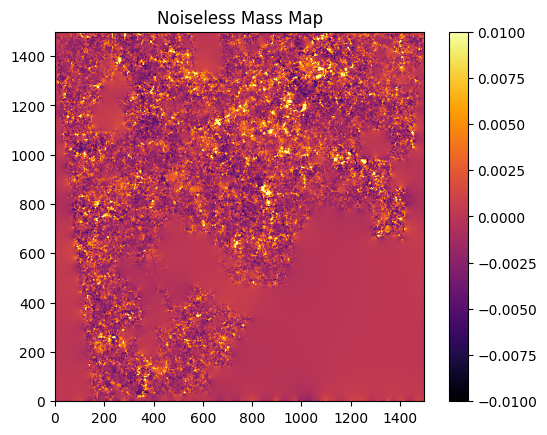

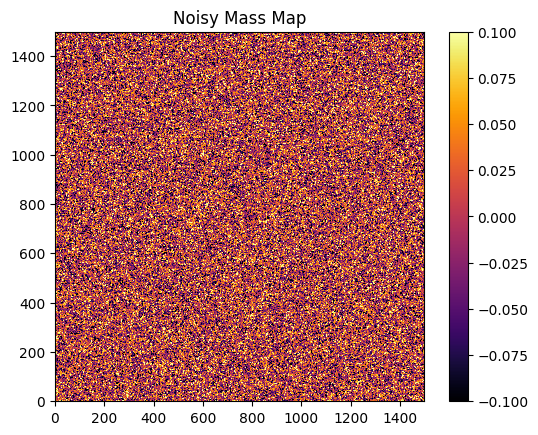

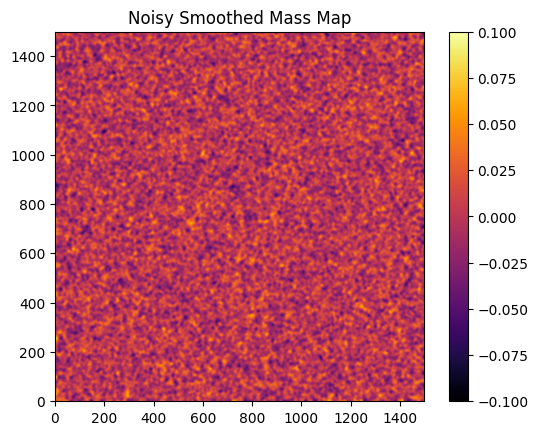

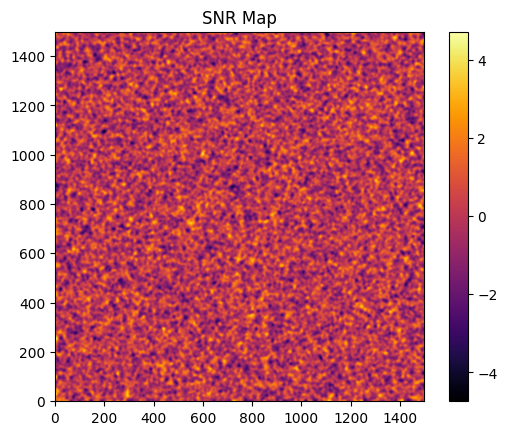

In [18]:
# Define the map data and titles
map_data = [kappaE, kappaE_noisy, kappaE_noisy_smoothed, snr]
titles = ['Noiseless Mass Map', 'Noisy Mass Map', 'Noisy Smoothed Mass Map', 'SNR Map']

# Define the vmin and vmax values for each map (adjust these values as needed)
vmin_values = [-0.01, -0.1, -0.1, None]
vmax_values = [0.01, 0.1, 0.1, None]

# Plot each map using the plot_map function
for data, title, vmin, vmax in zip(map_data, titles, vmin_values, vmax_values):
    plot_map(data, title=title, vmin=vmin, vmax=vmax)

Plot the SNR maps of the 5 different scales and the coarse map

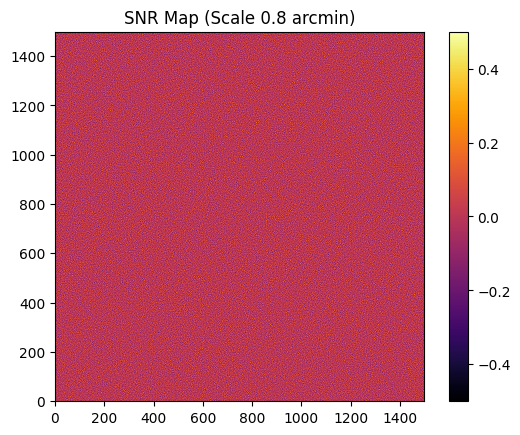

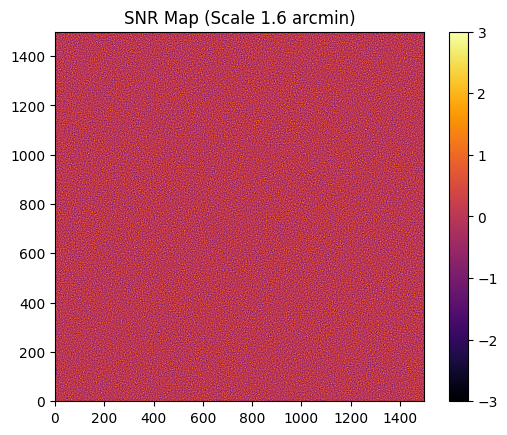

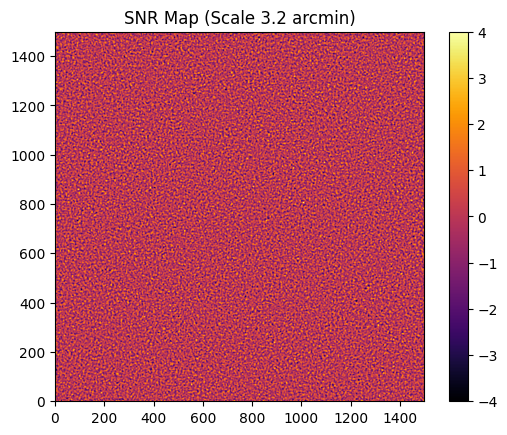

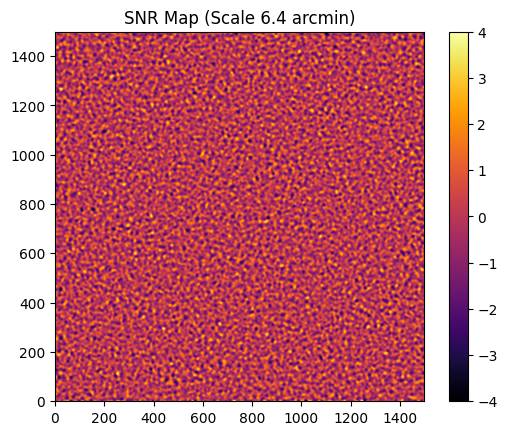

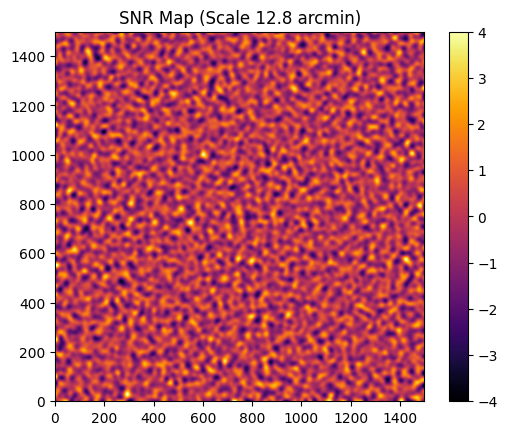

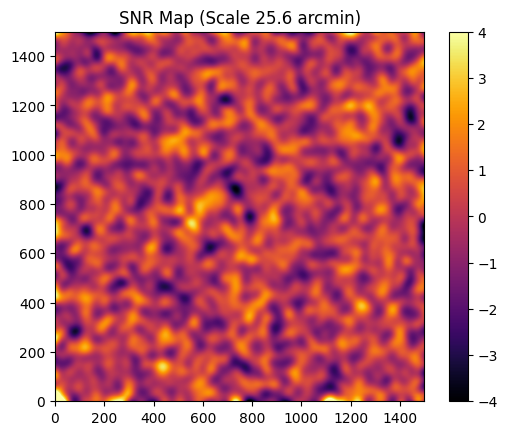

In [19]:
# Define vmin and vmax values for each SNR map
vmin_values = [-0.5, -3, -4, -4, -4, -4]  # Replace with your desired vmin values
vmax_values = [0.5, 3, 4, 4, 4, 4]  # Replace with your desired vmax values

scales_arcmin = [2**(i+1) * PIX_ARCMIN for i in range(len(multiscale_snr_maps))]

for i, (snr_map, scale_arcmin) in enumerate(zip(multiscale_snr_maps, scales_arcmin)):
    title = f"SNR Map (Scale {scale_arcmin:.1f} arcmin)"
    plot_map(snr_map, title=title, cmap='inferno', vmin=vmin_values[i], vmax=vmax_values[i])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


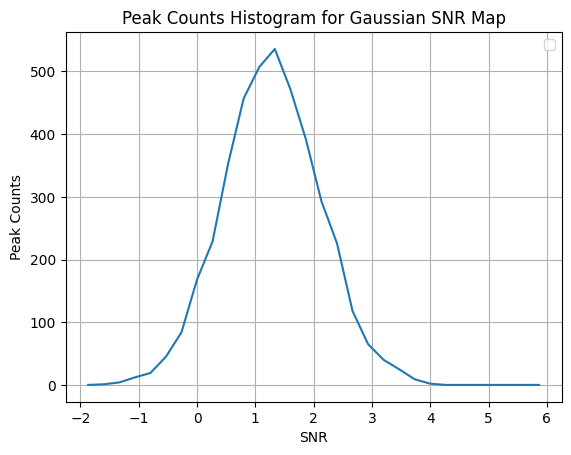

In [20]:
# Plot single-scale peak count histogram
plot_peak_count_histograms(kappa_th_center_snr, peak_counts_single, 
                           'Peak Counts Histogram for Gaussian SNR Map', 'SNR', 'Peak Counts')

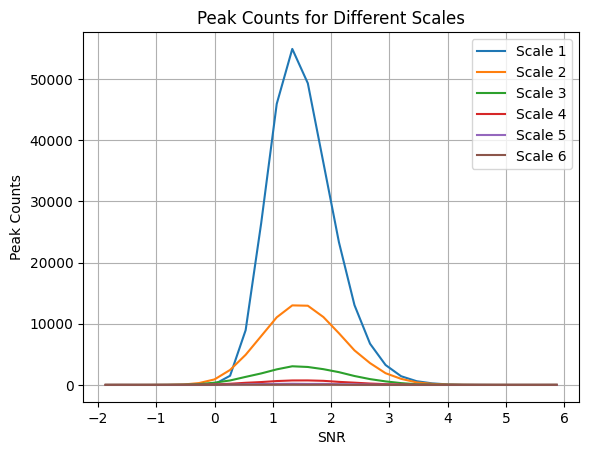

In [21]:
# Plot multiscale peak count histograms
plot_peak_count_histograms(kappa_th_center_snr, peak_counts_multi, 
                           'Peak Counts for Different Scales', 'SNR', 'Peak Counts', log_scale=False)

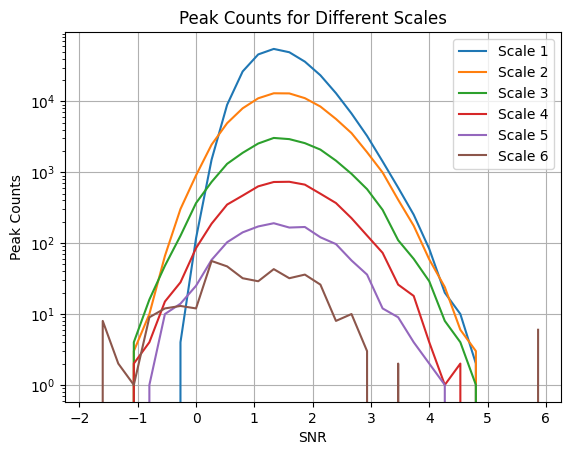

In [22]:
# Plot multiscale peak count histograms
plot_peak_count_histograms(kappa_th_center_snr, peak_counts_multi, 
                           'Peak Counts for Different Scales', 'SNR', 'Peak Counts', log_scale=True)

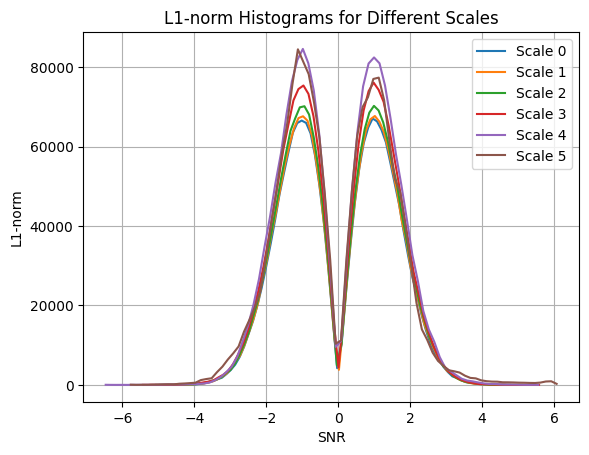

In [23]:
# Plot l1-norm histograms for different scales
plot_l1norm_histograms(bins_l1, l1norm_histogram, 'L1-norm Histograms for Different Scales', 'SNR', 'L1-norm', log_scale=False)